In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import sys
import os

### 1. Load Data

In [2]:
# Define the assets we'll analyze
assets = ['TSLA', 'BND', 'SPY']

# Define the time period
end_date = "2025-7-31"
start_date = "2015-07-01"


# Fetch the data
data = yf.download(assets, start=start_date, end=end_date)
print("\nData shape:", data.shape)

[*********************100%***********************]  3 of 3 completed


Data shape: (2535, 15)


In [3]:
## Save the dataset
data.to_csv('../data/raw/comp_hist_finance_data.csv')

In [4]:
sys.path.append(os.path.abspath('../src/'))

In [5]:
from preprocess import data_loader
df = data_loader('../data/raw/comp_hist_finance_data.csv')

### 2. Data Cleaning

In [6]:
from preprocess import reconstruct_from_two_row_csv, fetch_with_yfinance, prepare_time_index_and_interpolate, compute_returns_and_rolling, detect_outliers, compute_var_sharpe, adf_test, plot_series, plot_returns, plot_correlation

In [7]:
df.head()

,Price,Close,Close.1,Close.2,High,High.1,High.2,Low,Low.1,Low.2,Open,Open.1,Open.2,Volume,Volume.1,Volume.2
0,Ticker,BND,SPY,TSLA,BND,SPY,TSLA,BND,SPY,TSLA,BND,SPY,TSLA,BND,SPY,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-01,60.81673812866211,174.91708374023438,17.94333267211914,60.91446382420535,175.36385887691145,18.174667358398438,60.7641157179215,174.12468621850195,17.856666564941406,60.79418648626079,175.11096413509628,18.073999404907227,5399300,135979900,31518000
3,2015-07-02,60.96710205078125,174.75694274902344,18.667999267578125,61.027243603061514,175.5662034711772,18.829999923706055,60.93703127464112,174.3354557372848,18.220666885375977,60.93703127464112,175.39761123903432,18.68000030517578,1060100,104373700,107458500
4,2015-07-06,61.17756271362305,174.25958251953125,18.648000717163086,61.222671724131665,175.04354214835712,18.779333114624023,61.05728540155995,173.2564414233038,18.420000076293945,61.222671724131665,173.45875980949862,18.591999053955078,2210700,117975400,61828500


In [8]:
data_row = reconstruct_from_two_row_csv('../data/raw/comp_hist_finance_data.csv')

In [9]:
data_row.head()

,Date,BND_Close,SPY_Close,TSLA_Close,BND_High,SPY_High,TSLA_High,BND_Low,SPY_Low,TSLA_Low,BND_Open,SPY_Open,TSLA_Open,BND_Volume,SPY_Volume,TSLA_Volume
0,2015-07-01,60.816738,174.917084,17.943333,60.914464,175.363859,18.174667,60.764116,174.124686,17.856667,60.794186,175.110964,18.073999,5399300,135979900,31518000
1,2015-07-02,60.967102,174.756943,18.667999,61.027244,175.566203,18.830000,60.937031,174.335456,18.220667,60.937031,175.397611,18.680000,1060100,104373700,107458500
2,2015-07-06,61.177563,174.259583,18.648001,61.222672,175.043542,18.779333,61.057285,173.256441,18.420000,61.222672,173.458760,18.591999,2210700,117975400,61828500
3,2015-07-07,61.237713,175.355423,17.858667,61.470754,175.481864,18.346666,61.237713,172.059392,17.384666,61.410618,174.461873,18.333332,4183200,173820200,91576500
4,2015-07-08,61.410610,172.413498,16.997334,61.463233,174.293327,17.386667,61.312879,172.177466,16.954000,61.373020,174.006719,17.288000,1967800,164020100,93316500


In [10]:
 # find close columns
close_cols = [c for c in data_row.columns if c.endswith('_Close')]
if not close_cols:
    raise RuntimeError("No close columns detected in reconstructed CSV. Expected columns like TSLA_Close, SPY_Close, BND_Close")
# Make tidy df
tidy = data_row[['Date'] + close_cols].copy()

# Prepare time index and interpolation
df_clean = prepare_time_index_and_interpolate(tidy, close_cols)

In [11]:
df_clean.head()

,BND_Close,SPY_Close,TSLA_Close
Date,,,
2015-07-01,60.816738,174.917084,17.943333
2015-07-02,60.967102,174.756943,18.667999
2015-07-03,61.019717,174.632603,18.663000
2015-07-06,61.177563,174.259583,18.648001
2015-07-07,61.237713,175.355423,17.858667


In [12]:
# Save tidy cleaned close prices
tidy_out = '../data/processed/tidy_close_prices.csv'
df_clean.reset_index().to_csv(tidy_out, index=False)
print('Saved tidy close prices to', tidy_out)

Saved tidy close prices to ../data/processed/tidy_close_prices.csv


In [28]:
df_clean.head()

,BND_Close,SPY_Close,TSLA_Close
Date,,,
2015-07-01,60.816738,174.917084,17.943333
2015-07-02,60.967102,174.756943,18.667999
2015-07-03,61.019717,174.632603,18.663000
2015-07-06,61.177563,174.259583,18.648001
2015-07-07,61.237713,175.355423,17.858667


In [13]:
# Compute returns and rolling stats
returns, rolling_mean, rolling_std = compute_returns_and_rolling(df_clean)

In [14]:
 # Save returns
returns_out = '../data/processed/daily_returns.csv'
returns.reset_index().to_csv(returns_out, index=False)
print('Saved daily returns to', returns_out)

Saved daily returns to ../data/processed/daily_returns.csv


In [30]:
returns

,BND_Close,SPY_Close,TSLA_Close
Date,,,
2015-07-02,0.002472,-0.000916,0.040386
2015-07-03,0.000863,-0.000712,-0.000268
2015-07-06,0.002587,-0.002136,-0.000804
2015-07-07,0.000983,0.006289,-0.042328
2015-07-08,0.002823,-0.016777,-0.048231
...,...,...,...
2025-07-24,-0.001232,0.000331,-0.081970
2025-07-25,0.002468,0.004224,0.035244
2025-07-28,-0.001641,-0.000251,0.030152


In [15]:
 # Outliers
outlier_days, _mask = detect_outliers(returns)
outlier_out = '../data/processed/outlier_days.csv'
outlier_days.reset_index().to_csv(outlier_out, index=False)
print('Saved outlier days to', outlier_out)

Saved outlier days to ../data/processed/outlier_days.csv


In [31]:
outlier_days

,BND_Close,SPY_Close,TSLA_Close
Date,,,
2015-08-24,-0.000244,-0.042107,-0.051567
2015-08-26,-0.004282,0.038394,0.021861
2015-11-04,0.000615,-0.003033,0.111735
2016-06-24,0.005647,-0.035909,-0.016548
2018-02-05,0.004379,-0.041823,-0.030895
...,...,...,...
2025-04-04,0.000813,-0.058543,-0.104198
2025-04-07,-0.012056,-0.001781,-0.025644
2025-04-09,0.002345,0.105019,0.226900


In [16]:
 # Risk metrics
VaR, sharpe_annual = compute_var_sharpe(returns)
VaR.to_csv('../data/processed/VaR.csv')
sharpe_annual.to_csv('../data/processed/Sharpe_annual.csv')


In [32]:
sharpe_annual

BND_Close     0.352528
SPY_Close     0.783723
TSLA_Close    0.765979
dtype: float64

In [17]:
# Statsmodels for ADF
try:
    from statsmodels.tsa.stattools import adfuller
    STATSMODELS_AVAILABLE = True
except Exception:
    STATSMODELS_AVAILABLE = False

In [18]:
# ADF tests
adf_results = {}
if STATSMODELS_AVAILABLE:
    for c in df_clean.columns:
        adf_results[c] = adf_test(df_clean[c])
    for c in returns.columns:
        adf_results[f"{c}_returns"] = adf_test(returns[c])
    # Save ADF summary
    with open('../data/processed/adf_results.txt', 'w') as f:
        for k,v in adf_results.items():
            f.write(f"{k}: p={v['pvalue']}, adf_stat={v['adf_stat']}\n")
else:
    print('statsmodels not available; skipping ADF tests')

In [19]:
# Save cleaned dataframe for modeling
df_clean.reset_index().to_csv('../data/processed/clean_close_prices_for_analysis.csv', index=False)

In [20]:
outdir = "../data"

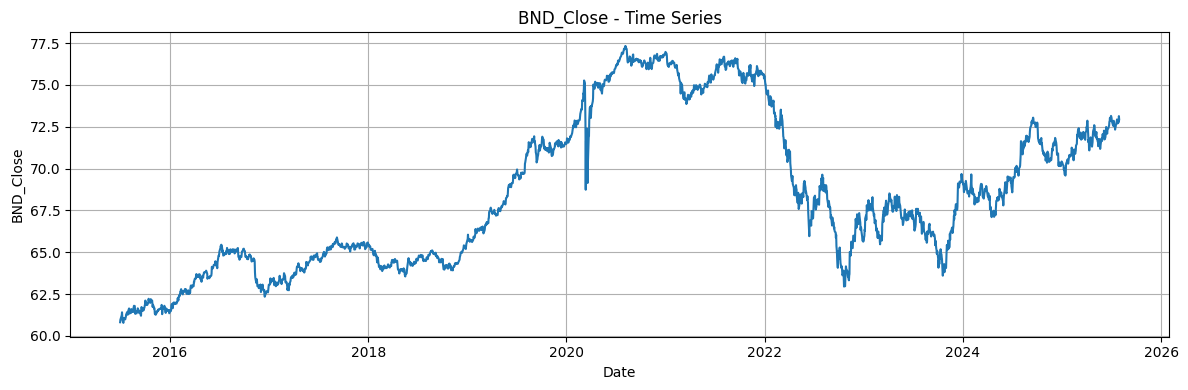

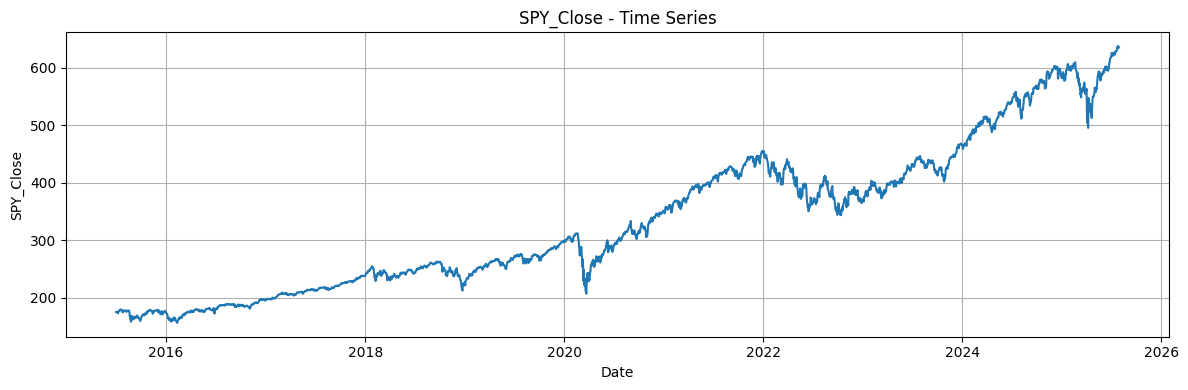

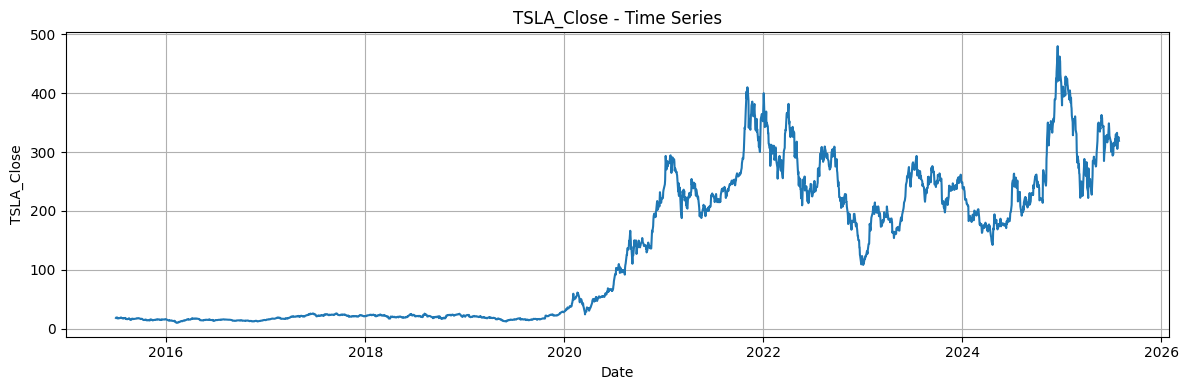

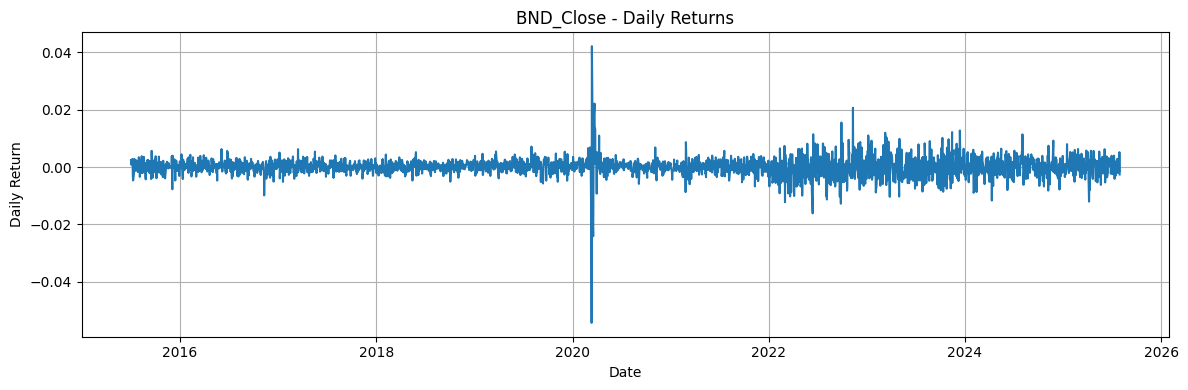

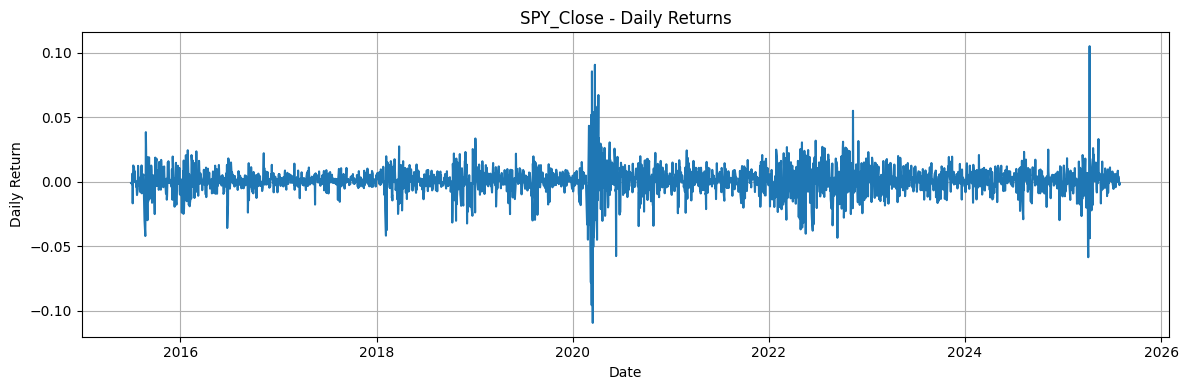

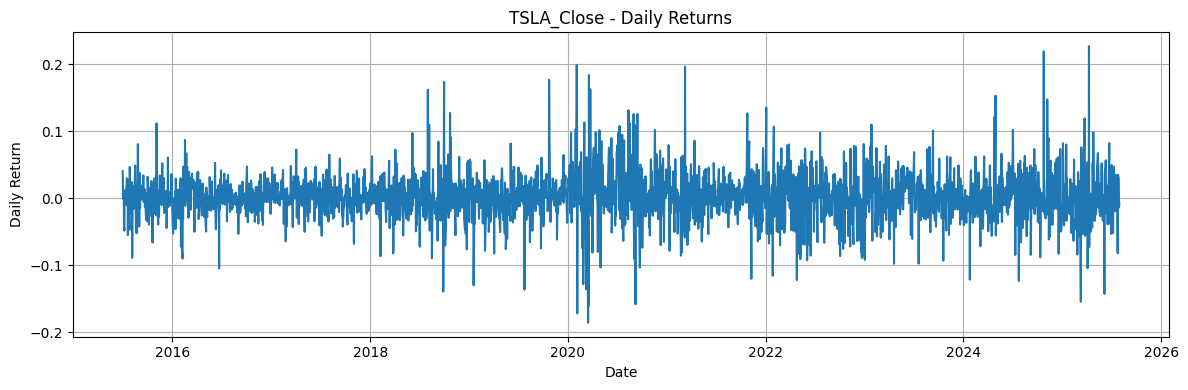

In [21]:
# Plots
plot_series(df_clean, outdir, prefix='close_')
plot_returns(returns, outdir)

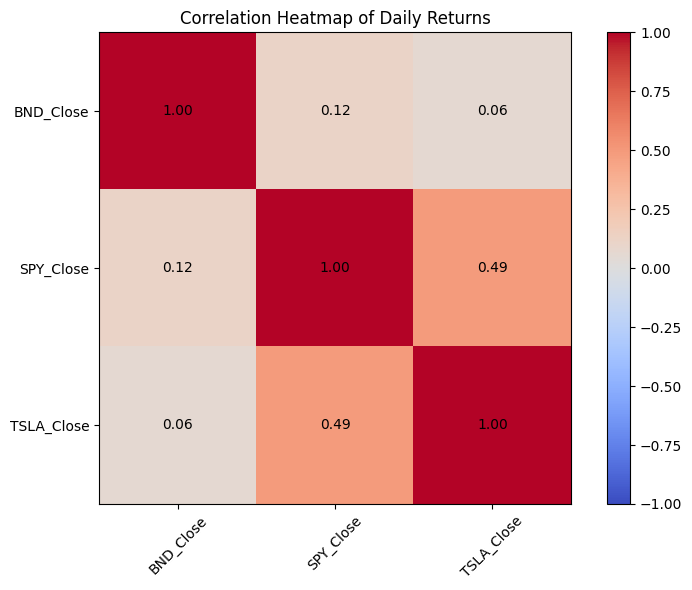

In [22]:
# New: Correlation heatmap
plot_correlation(returns, outdir)

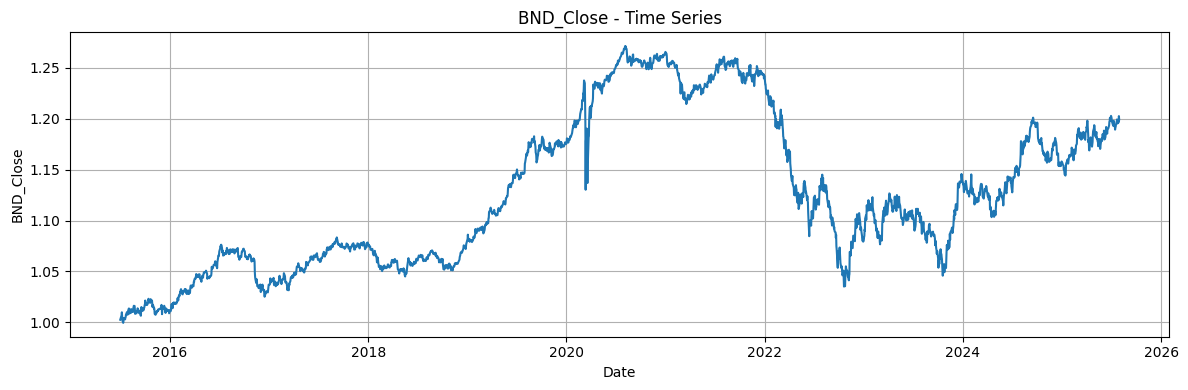

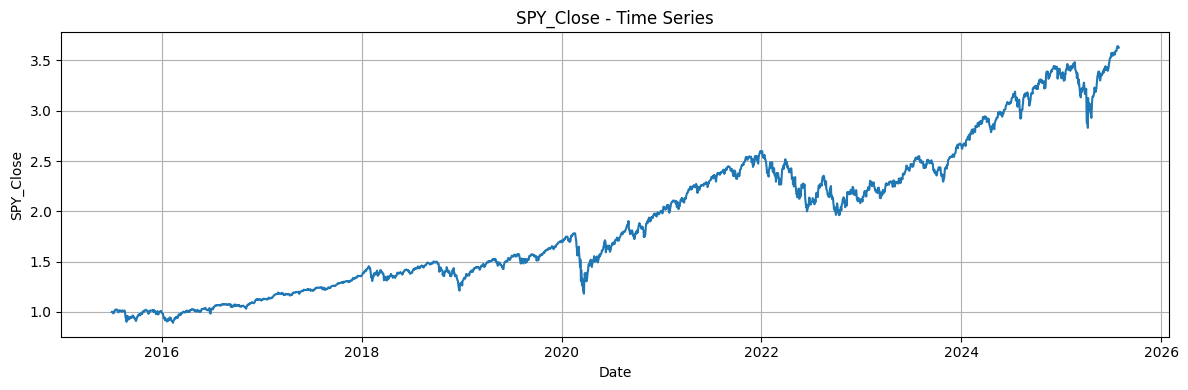

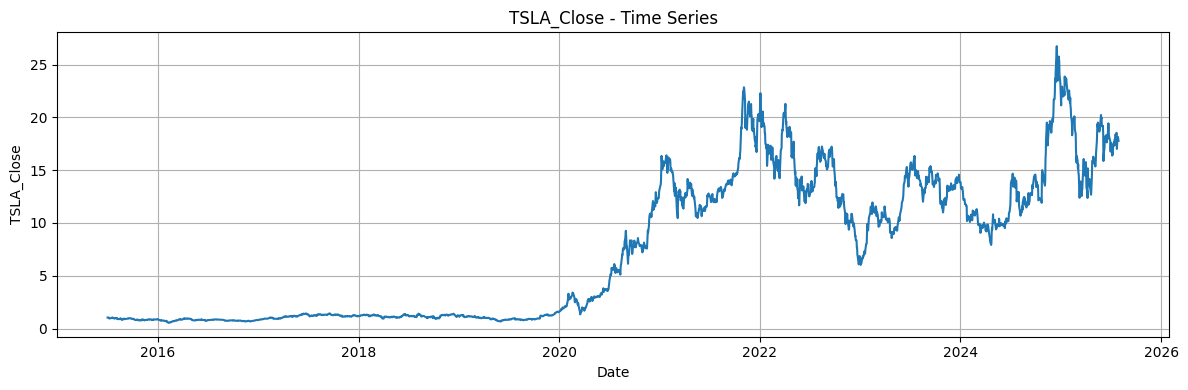

In [23]:
# New: Cumulative returns
cum_returns = (1 + returns).cumprod()
plot_series(cum_returns, outdir, prefix='cum_returns_')

In [24]:
from pathlib import Path

In [25]:
outdir = Path(outdir)

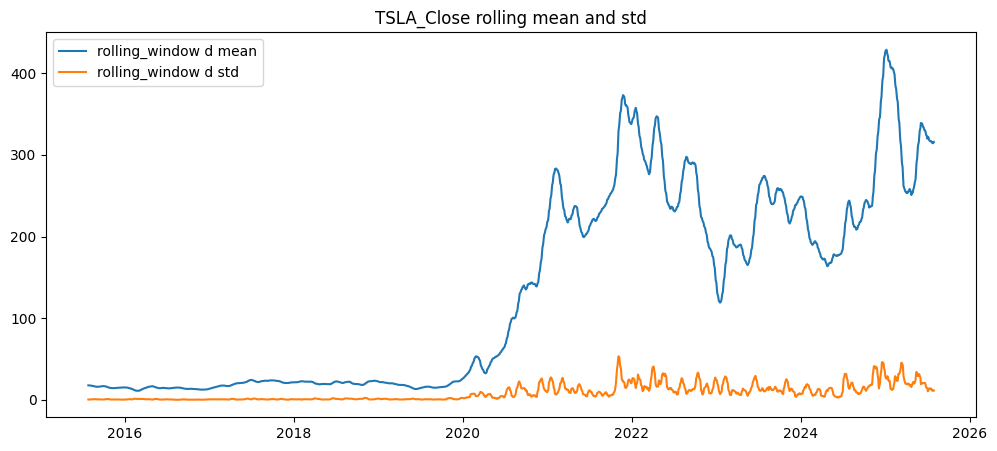

In [26]:
# Rolling mean/std example plot for TSLA (if present)
example_col = None
for candidate in ['TSLA_Close', 'SPY_Close', 'BND_Close']:
    if candidate in df_clean.columns:
        example_col = candidate
        break
if example_col:
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df_clean.index, df_clean[example_col].rolling(20).mean(), label='rolling_window d mean')
    ax.plot(df_clean.index, df_clean[example_col].rolling(20).std(), label='rolling_window d std')
    ax.set_title(f"{example_col} rolling mean and std")
    ax.legend()
    fig.savefig(outdir / f"{example_col}_rolling_mean_std.png")
    plt.show(fig)
    #plt.close(fig)

In [27]:
# Print a short summary to console
print('\n=== Summary ===')
print('Sample means of daily returns:')
print(returns.mean().to_string())
print('\nSample std dev of daily returns:')
print(returns.std().to_string())
print('\nVaR:')
print(VaR.to_string())
print('\nAnnualized Sharpe (rf=' + str(0.0) + '):')
print(sharpe_annual.to_string())


=== Summary ===
Sample means of daily returns:
BND_Close     0.000075
SPY_Close     0.000553
TSLA_Close    0.001745

Sample std dev of daily returns:
BND_Close     0.003371
SPY_Close     0.011199
TSLA_Close    0.036156

VaR:
      BND_Close  SPY_Close  TSLA_Close
0.05  -0.004747  -0.016688   -0.052559
0.01  -0.008674  -0.032895   -0.090587

Annualized Sharpe (rf=0.0):
BND_Close     0.352528
SPY_Close     0.783723
TSLA_Close    0.765979
